In [141]:
import pandas as pd
pd.set_option('display.max_rows', 500)
import numpy as np
import matplotlib.pyplot as plt
import os
import seaborn as sns
import tensorflow as tf
from tensorflow.keras import layers, optimizers, models

from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier

base = "../data/Deployment_1/"

## 1. Data loading

In [142]:
data = pd.read_csv(base + "dataset_1_preprocessing_with_mean_value.csv")
df_train = data.copy()

## 2. Data processing

In [143]:
df_train = df_train.fillna(0)
df_train["Time"] = df_train["Hour"]*60 + df_train["Minute"]

df_train_without_ignore = df_train[df_train["Label"]!=7]
df_train_without_ignore = df_train_without_ignore.reset_index(drop=True)

In [144]:
df_train_without_ignore.head()

,TimeID,Hour,Minute,Date,Label,Name,sensor5,sensor6,sensor8,sensor9,...,sensor23,sensor24,sensor25,sensor30,sensor31,sensor32,sensor34,sensor35,sensor40,Time
0,2013-03-04-20-58,20,58,2013-03-04,4.0,Working at PC,0.0,0.0,66.000000,0.0,...,0.0,0.0,0.0,1.090909,0.0,0.0,197.545455,34.181818,2.181818,1258
1,2013-03-04-20-59,20,59,2013-03-04,4.0,Working at PC,0.0,0.0,66.000000,0.0,...,0.0,0.0,0.0,1.000000,0.0,0.0,200.166667,32.833333,2.000000,1259
2,2013-03-04-21-00,21,0,2013-03-04,4.0,Working at PC,0.0,0.0,64.333333,0.0,...,0.0,0.0,0.0,0.909091,0.0,0.0,198.083333,33.272727,2.000000,1260
3,2013-03-04-21-01,21,1,2013-03-04,4.0,Working at PC,0.0,0.0,64.000000,0.0,...,0.0,0.0,0.0,1.090909,0.0,0.0,199.500000,33.090909,2.000000,1261
4,2013-03-04-21-02,21,2,2013-03-04,4.0,Working at PC,0.0,0.0,64.000000,0.0,...,0.0,0.0,0.0,0.909091,0.0,0.0,200.454545,32.181818,2.000000,1262


In [145]:
# df_freq = pd.DataFrame(df_train["Date"].value_counts()).reset_index().sort_values(by="index")
# df_freq = df_freq.rename(columns={"index":"Date", "Date":"Count"})
# df_freq_1_hour = df_freq[df_freq["Count"]>60]
# df_freq_2_hour = df_freq[df_freq["Count"]>120]
# df_freq_1_hour

#### Filling "Ignore" by using the best action prediction model from part 1

In [146]:
encoder = LabelEncoder()

X = df_train_without_ignore.drop(["Label", "TimeID", "Date", "Name", "Hour", "Minute"], axis=1)
X = np.array(X)
y = encoder.fit_transform(df_train_without_ignore["Name"])

In [147]:
rf_model = RandomForestClassifier(n_estimators=360, 
                                  bootstrap=False,
                                  max_depth=6,
                                  min_samples_leaf=2, 
                                  min_samples_split=2,
                                  random_state=18)

rf_model.fit(X, y)

RandomForestClassifier(bootstrap=False, max_depth=6, min_samples_leaf=2,
                       n_estimators=360, random_state=18)

In [148]:
rf_model.score(X, y)

0.8767809521003079

In [149]:
df_ignore = df_train[df_train["Label"]==7]
df_ignore = df_ignore.reset_index(drop=True)
df_ignore = df_ignore.drop(["Label", "TimeID", "Date", "Name", "Hour", "Minute"], axis=1)

y_pred = rf_model.predict(np.array(df_ignore))

In [150]:
df_train.loc[df_train["Label"]==7, "Name"] = encoder.inverse_transform(y_pred)

### Preparing data for training

In [152]:
encoder = LabelEncoder()

train_data = df_train.drop(["Label", "TimeID", "Date", "Name", "Hour", "Minute"], axis=1)
train_data = np.array(train_data)
train_labels = encoder.fit_transform(df_train["Name"])

print(train_data.shape, train_label.shape)

(140844, 19) (140844,)


In [166]:
def make_data(timesteps, ratio=0.5, train_data=train_data, train_labels=train_labels):
    X_data = np.zeros([train_data.shape[0]-timesteps, timesteps, train_data.shape[1]])
    y_data = train_label[timesteps:]
    for i in range(timesteps):
        X_data[:,i,:] = train_data[i:X_data.shape[0]+i]
    
    split_idx = int(len(X_data)*ratio)

    X_train, X_test = X_data[:split_idx], X_data[split_idx:]
    y_train, y_test = y_data[:split_idx], y_data[split_idx:]
    
    return X_train, y_train, X_test, y_test 

## 3. Training

In [167]:
histories = []

for timesteps in [30, 60, 120]:
    X_train, y_train, X_test, y_test = make_data(timesteps)
    
    tf.keras.backend.clear_session()
    
    inputs = layers.Input(shape=(X_train.shape[1:]))
    x = layers.LSTM(128, return_sequences=True)(inputs)
    x = layers.LSTM(128)(x)
    outputs = layers.Dense(9, activation="softmax")(x)

    model = models.Model(inputs, outputs)
    model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                  optimizer=optimizers.Adam(),
                  metrics=["accuracy"])

    history = model.fit(X_train, y_train, epochs=50, batch_size=500, validation_data=(X_test, y_test))
    histories.append(history)

Train on 70407 samples, validate on 70407 samples
Epoch 1/50
70407/70407 [==============================] - 6s 83us/sample - loss: 1.6050 - accuracy: 0.7750 - val_loss: 1.5525 - val_accuracy: 0.8210
Epoch 2/50
70407/70407 [==============================] - 2s 30us/sample - loss: 1.5074 - accuracy: 0.8651 - val_loss: 1.5237 - val_accuracy: 0.8490
Epoch 3/50
70407/70407 [==============================] - 2s 30us/sample - loss: 1.4973 - accuracy: 0.8753 - val_loss: 1.5373 - val_accuracy: 0.8342
Epoch 4/50
70407/70407 [==============================] - 2s 30us/sample - loss: 1.4989 - accuracy: 0.8736 - val_loss: 1.5204 - val_accuracy: 0.8516
Epoch 5/50
70407/70407 [==============================] - 2s 30us/sample - loss: 1.4962 - accuracy: 0.8760 - val_loss: 1.5396 - val_accuracy: 0.8342
Epoch 6/50
70407/70407 [==============================] - 2s 30us/sample - loss: 1.4939 - accuracy: 0.8781 - val_loss: 1.5140 - val_accuracy: 0.8585
Epoch 7/50
70407/70407 [==============================] 

70392/70392 [==============================] - 4s 50us/sample - loss: 1.4848 - accuracy: 0.8876 - val_loss: 1.5133 - val_accuracy: 0.8586
Epoch 6/50
70392/70392 [==============================] - 4s 51us/sample - loss: 1.4942 - accuracy: 0.8780 - val_loss: 1.5025 - val_accuracy: 0.8699
Epoch 7/50
70392/70392 [==============================] - 4s 50us/sample - loss: 1.4802 - accuracy: 0.8921 - val_loss: 1.4834 - val_accuracy: 0.8886
Epoch 8/50
70392/70392 [==============================] - 4s 50us/sample - loss: 1.4813 - accuracy: 0.8910 - val_loss: 1.4987 - val_accuracy: 0.8731
Epoch 9/50
70392/70392 [==============================] - 4s 51us/sample - loss: 1.4952 - accuracy: 0.8770 - val_loss: 1.5066 - val_accuracy: 0.8653
Epoch 10/50
70392/70392 [==============================] - 4s 52us/sample - loss: 1.4884 - accuracy: 0.8839 - val_loss: 1.4953 - val_accuracy: 0.8769
Epoch 11/50
70392/70392 [==============================] - 4s 50us/sample - loss: 1.4896 - accuracy: 0.8829 - val_lo

## 4. Evaluation

In [168]:
def plot(epochs, history):
    loss = history.history["loss"]
    val_loss = history.history["val_loss"]
    acc = history.history["accuracy"]
    val_acc = history.history["val_accuracy"]
    legends = ["training", "validation"]
    print(f"Highest accuracy {np.max(val_acc)} at epoch {np.argmax(val_acc) + 1}")
    
    fig, axs = plt.subplots(1, 2, figsize=(15, 5))
    axs = axs.flatten()
    axs[0].plot(np.arange(1,epochs+1), acc, marker="o")
    axs[0].plot(np.arange(1,epochs+1), val_acc, marker="D")
    axs[0].legend(legends)
    axs[0].grid(True)
    
    axs[1].plot(np.arange(1,epochs+1), loss, marker="o")
    axs[1].plot(np.arange(1,epochs+1), val_loss, marker="D")
    axs[1].legend(legends)
    axs[1].grid(True)
    
    plt.show()

Highest accuracy 0.8974107503890991 at epoch 24


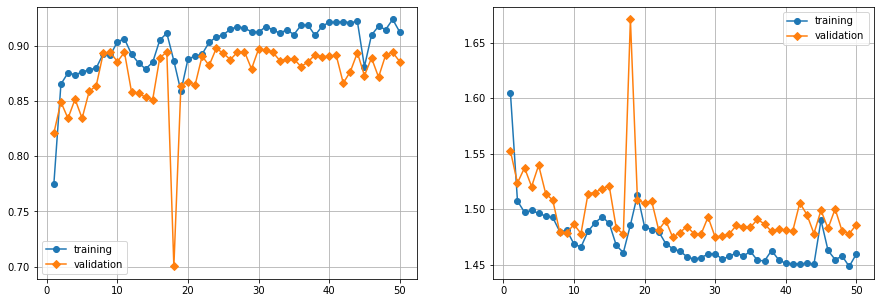

In [169]:
plot(50, histories[0])

Highest accuracy 0.9000738859176636 at epoch 50


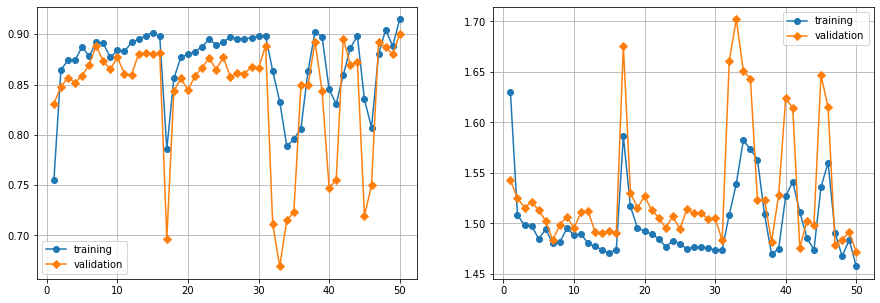

In [170]:
plot(50, histories[1])

Highest accuracy 0.8844262361526489 at epoch 33


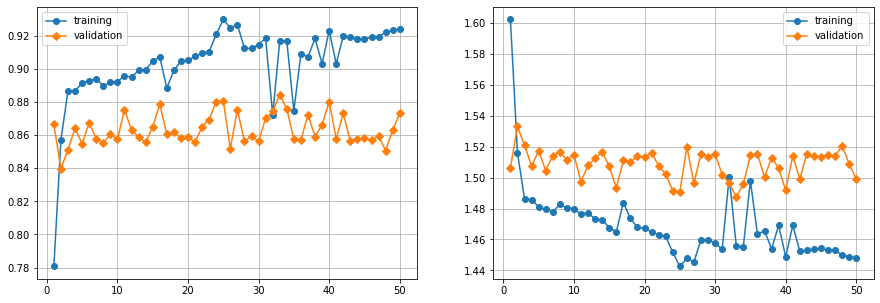

In [171]:
plot(50, histories[2])